# Functional Approach to Querying the IMDb Database

The Internet Movie Database (IMDb) is an online database of information related to films, television programs, home videos, and video games. Users can access details about movies, TV shows, actors, directors, production crew, and more on IMDb. It's widely used by industry professionals, film enthusiasts, and general audiences for research, reviews, ratings, and recommendations.

A subset of the IMDb data was used to create an SQLite database file `imdb.db` that contains data the available data through 3/27/2022.  In this notebook we define a Python function `analyzeActor(dbcon, actor_name)` that will perform SQL queries to the IMDb database (with the connection `dbcon`) to determine some interesting facts about the provided actor/actress (`actor_name`).  Specifically, the function only examines movies (as opposed to TV shows, etc) and displays the following information:

- The first appearance of the actor (title of movie, year the movie premiered, the character the actor played, and the age of the actor at that time).

- The last appearance of the actor (title of movie, year the movie premiered, the character the actor played, and the age of the actor at that time).

- The actor’s lowest rated movie.

- The actor’s highest rated movie.

- A line graph of the number of movies the actor was involved in for each year over their career.

## Import the needed libraries

We begin by importing the libraries that we will need.

In [1]:
import sqlalchemy as sa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

## Connect to the IMDb database

Now we connect to the sqlite IMDb database which is assumed to be in the **same directory as this notebook.**

In [2]:
cstring = 'sqlite+pysqlite:///imdb.db'
engine = sa.create_engine(cstring)
connection = engine.connect()

## Function Definition

In the code cell below we define the`analyzeActor(dbcon, actor_name)` function.  This function is designed to analyze and provide insights about an actor's career based on data strored in the `imdb.db` database. Here's a breakdown of what it does:

**SQL Query Construction:** The function constructs SQL queries using a text-based approach with *binding*. These queries are used to extract specific information from the database related to the actor's appearances in movies.

**Executing SQL Queries:** After constructing the SQL queries, the function *binds* the necessary parameters (like the actor's name) and executes the queries using Pandas' `read_sql_query()` function to read the SQL results into a DataFrame.

**Textual Output:** The function then prints out textual information about the actor's career, including their first and last appearances in movies, their roles, the movies' premier dates, and the age of the actor at the time of premier. It also highlights the lowest and highest-rated movies the actor appeared in.

**Data Visualization:** The function also generates a line graph showing the number of movies the actor appeared in each year. It constructs another SQL query to retrieve this data, processes it in Pandas to ensure every year is represented (even if no movies were released), and then uses Matplotlib to create and display the line graph.

In [3]:
def analyzeActor(dbcon, actor_name):
    
    # Define the SQL query needed for the text output using the binding method
    pyquery = """
    SELECT name, primary_title, premiered, characters, (premiered-born) AS age_at_premier, rating
    FROM titles
    LEFT JOIN crew USING(title_id)
    LEFT  JOIN people USING(person_id)
    LEFT  JOIN ratings USING(title_id)
    WHERE name = :name_in
    AND type = 'movie'
    """
    
    # Bind the query
    prepare_stmt = sa.sql.text(pyquery)
    bound_stmt = prepare_stmt.bindparams(name_in = actor_name)
    
    # Pass the query to the DBMS and obtain the resulting table as a dataframe
    df = pd.read_sql_query(bound_stmt, dbcon)

    print("=================================================")
    print("Actor: " + actor_name)
    print("=================================================")
    print()

    # Print the textual output
    print("First appearance:")
    print("=================")
    first = df.premiered.argmin()

    num = len(df.characters[first])
    name = df.characters[first][2:num-2]

    print(str(int(df.premiered[first])) + ": " + "Played " + name +
          ' in "' +
          df.primary_title[first] + 
          '" (at age ' + str(df.age_at_premier[first]) + ")")

    print()
    print("Last appearance:")
    print("=================")
    last = df.premiered.argmax()

    num = len(df.characters[last])
    name = df.characters[last][2:num-2]

    print(str(int(df.premiered[last])) + ": " + "Played " + name +
          ' in "' +
          df.primary_title[last] + 
          '" (at age ' + str(df.age_at_premier[last]) + ")")

    print()

    lowest = df.rating.argmin()
    print("Lowest rated movie: " + df.primary_title[lowest] + "  (rating = " 
          + str(df.rating[lowest]) + ")")

    highest = df.rating.argmax()
    print("Highest rated movie: " + df.primary_title[highest] + "  (rating = " 
          + str(df.rating[highest]) + ")")

    ###################################################
    
    # Define the SQL query needed for the line graph using the binding method
    pyquery = """
    SELECT DISTINCT premiered, count(primary_title) AS num_movies
    FROM titles
    INNER JOIN crew USING(title_id)
    INNER JOIN people USING(person_id)
    WHERE name = :name_in
    AND type = 'movie'
    AND premiered IS NOT NULL
    GROUP BY premiered
    """

    # Bind the query
    prepare_stmt = sa.sql.text(pyquery)
    bound_stmt = prepare_stmt.bindparams(name_in = actor_name)
    
    # Pass the query to the DBMS and obtain the resulting table as a dataframe
    df = pd.read_sql_query(bound_stmt, dbcon)
    
    # Update the dataframe so that every year is present, including years where
    #   the number of movies is zero
    first = df.premiered.min()
    last = df.premiered.max()    
    years = np.arange(first,last+1).astype(int)
    
    df.set_index("premiered", inplace=True)

    df = df.reindex(years ,fill_value=0)
    
    # Create and display the plot
    plt.plot(df.index.values,df.num_movies)
    plt.title("Number of Movies Per Year")
    plt.xlabel("Year")
    plt.ylabel("Number of Movies")
    
    # Ensure that the y-axis ticks are integer valued
    new_list = range(math.floor(min(df.num_movies)), math.ceil(max(df.num_movies))+1)
    plt.yticks(new_list)
    
    plt.show()

## Test Case 1: Tom Cruise

Below we test our function to see what we can find out about Tom Cruise

Actor: Tom Cruise

First appearance:
1982: Played Woody in "Losin' It" (at age 20.0)

Last appearance:
2024: Played Ethan Hunt in "Mission: Impossible 8" (at age 62.0)

Lowest rated movie: Losin' It  (rating = 4.9)
Highest rated movie: Success Formula  (rating = 9.9)


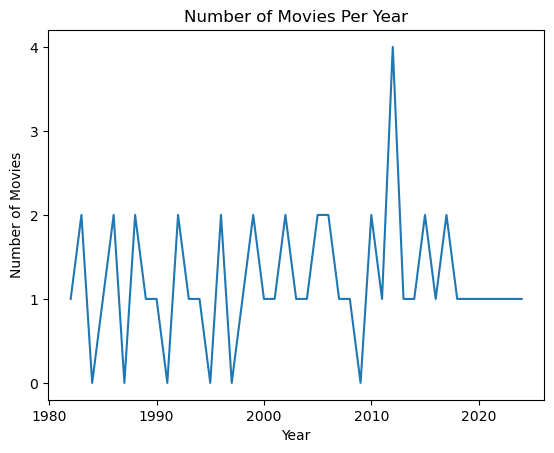

In [4]:
analyzeActor(connection, "Tom Cruise")

### Analysis of Output

<u>Career Overview</u>

**Longevity:** Tom Cruise has had a remarkably long and consistent career in Hollywood. His first film was in 1982, and he's still actively making movies as of 2024. This indicates a 40+ year career at the top of the industry.

**Steady Work:** He almost always appears in at least one movie per year, with some years seeing multiple releases. This showcases his constant work ethic and demand in the industry.

**Critical Reception:** His movies range in ratings, including some less well-received films ("Losin' It"). However, this doesn't appear to have dented his popularity or demand.

<u>Interesting Notes</u>

**Early Start:** He began his film career at the young age of 20.
Gaps in Work: There are a few years where he didn't have any film premieres (1984, 1987, 1991, 1995, 1997, 2009). This might suggest periods of focusing on other projects, taking time off, or simply not finding the right roles.

**Active Late Career:** Even at age 62, he's still a headlining actor, particularly notable in action-oriented franchises like "Mission: Impossible".

## Test Case 2: Warren Beatty

Below we test our function to see what we can find out about Warren Beatty

Actor: Warren Beatty

First appearance:
1961: Played Paolo di Leo in "The Roman Spring of Mrs. Stone" (at age 24.0)

Last appearance:
2021: Played Self in "Live at Mister Kelly's" (at age 84.0)

Lowest rated movie: Town & Country  (rating = 4.5)
Highest rated movie: Live at Mister Kelly's  (rating = 8.3)


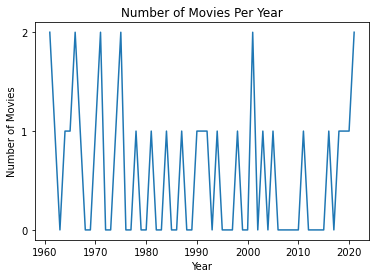

In [5]:
analyzeActor(connection, "Warren Beatty")

### Analysis of Output

<u>Career Overview</u>

**Span:** Beatty's career in film spans an impressive six decades, starting in 1961 and continuing (at least) until 2021.

**Prolific Early Years:** Beatty was very active in the 1960s and 1970s, often appearing in multiple films per year.

**Inconsistent Output:** His work output became less consistent after the 1970s, with several years seeing zero film premieres. This suggests selectivity in projects or potential focus on other ventures (like directing and producing).

**Late Career Appearances:** Even in his 80s, Warren Beatty continued to make occasional film appearances.

<u>Interesting Notes</u>

**Early Start:** He started his film career relatively young, at the age of 24.

**Critical Reception:** His lowest-rated movie, "Town & Country," is a critical flop. Still, his overall career features many acclaimed performances and films.

**Hiatuses:** There are several multi-year periods where he didn't have any film premieres (1968-69, 1976-77, 1979-80, etc.). This might point to extended breaks or involvement in behind-the-scenes work like directing, producing, or writing.

**Focus Shift:** His career potentially demonstrates a gradual shift towards fewer acting roles, perhaps prioritizing other creative aspects of filmmaking as he got older.